In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset

In [3]:
folder_path = "/home/vmeshchaninov/nlp_models/data/rocstories/"

In [4]:
df = pd.read_csv(os.path.join(folder_path, '100KStories.csv'))
df.head()

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,9a51198e-96f1-42c3-b09d-a3e1e067d803,Overweight Kid,Dan's parents were overweight.,Dan was overweight as well.,The doctors told his parents it was unhealthy.,His parents understood and decided to make a c...,They got themselves and Dan on a diet.
1,617e7ada-3878-488d-bd56-40695b91f053,The Bike Accident,Carrie had just learned how to ride a bike.,She didn't have a bike of her own.,Carrie would sneak rides on her sister's bike.,She got nervous on a hill and crashed into a w...,The bike frame bent and Carrie got a deep gash...
2,79b0da1f-e460-4173-ba58-8c9e2553c53a,Beach,Morgan enjoyed long walks on the beach.,She and her boyfriend decided to go for a long...,"After walking for over a mile, something happe...",Morgan decided to propose to her boyfriend.,Her boyfriend was upset he didn't propose to h...
3,d173b7de-4611-4cdf-934c-912834755e41,The bad customer.,Jane was working at a diner.,"Suddenly, a customer barged up to the counter.",He began yelling about how long his food was t...,Jane didn't know how to react.,"Luckily, her coworker intervened and calmed th..."
4,af0fd5a4-de36-47ba-8aa2-e99d10986d7a,Being Patient,I was talking to my crush today.,She continued to complain about guys flirting ...,I decided to agree with what she says and list...,"After I got home, I got a text from her.",She asked if we can hang out tomorrow.


In [5]:
df.drop(columns=['storyid', 'storytitle'], inplace=True)

In [6]:
texts = []
for i in range(len(df)):
    text = ''
    for j in range(1, 6):
        text += df[f'sentence{j}'][i] + ' '
        
    texts.append(text.strip())

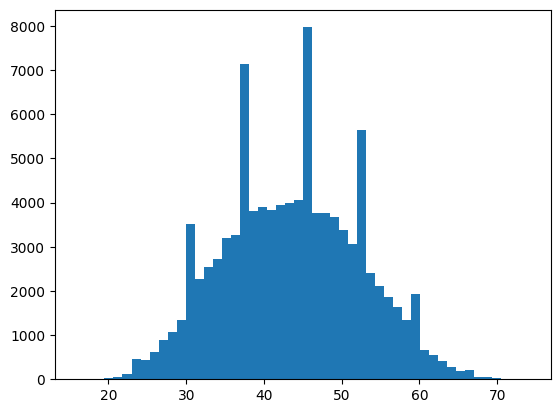

In [7]:
lens = [len(t.split()) for t in texts]
plt.hist(lens, bins=50);

Предобработка SSD-LM: https://github.com/xhan77/ssd-lm/blob/c0b67612c27928350aa073b303bc9df3a0e87f28/ssd_process_data.py#L430 

In [8]:
raw_dataset = Dataset.from_list([{"text": t} for t in texts])

In [9]:
raw_dataset

Dataset({
    features: ['text'],
    num_rows: 98167
})

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [11]:
def tokenize_function(batch):
    return tokenizer(batch["text"], return_special_tokens_mask=True)

In [12]:
tokenized_dataset = raw_dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=["text"],
    desc="Running tokenizer on every text in dataset",
)

Running tokenizer on every text in dataset (num_proc=4):   0%|          | 0/98167 [00:00<?, ? examples/s]

In [13]:
max_seq_length = 100

In [14]:
tokenized_dataset = tokenized_dataset.remove_columns(["attention_mask", "token_type_ids"])

In [15]:
def group_texts(batch):
    # Concatenate all texts.
    concatenated_batch = {k: sum(batch[k], []) for k in batch.keys()}
    total_length = len(concatenated_batch[list(batch.keys())[0]])
    
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= max_seq_length:
        total_length = (total_length // max_seq_length) * max_seq_length
    
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + max_seq_length] for i in range(0, total_length, max_seq_length)]
        for k, t in concatenated_batch.items()
    }
    return result

In [16]:
tokenized_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    num_proc=4,
    desc=f"Grouping texts in chunks of {max_seq_length}",
)

Grouping texts in chunks of 100 (num_proc=4):   0%|          | 0/98167 [00:00<?, ? examples/s]

In [17]:
print(tokenized_dataset[0])

{'input_ids': [101, 4907, 1005, 1055, 3008, 2020, 2058, 11179, 1012, 4907, 2001, 2058, 11179, 2004, 2092, 1012, 1996, 7435, 2409, 2010, 3008, 2009, 2001, 4895, 20192, 24658, 2100, 1012, 2010, 3008, 5319, 1998, 2787, 2000, 2191, 1037, 2689, 1012, 2027, 2288, 3209, 1998, 4907, 2006, 1037, 8738, 1012, 102, 101, 13223, 2018, 2074, 4342, 2129, 2000, 4536, 1037, 7997, 1012, 2016, 2134, 1005, 1056, 2031, 1037, 7997, 1997, 2014, 2219, 1012, 13223, 2052, 13583, 12271, 2006, 2014, 2905, 1005, 1055, 7997, 1012, 2016, 2288, 6091, 2006, 1037, 2940, 1998, 8007, 2046, 1037, 2813, 1012, 1996, 7997, 4853, 6260, 1998, 13223, 2288], 'special_tokens_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


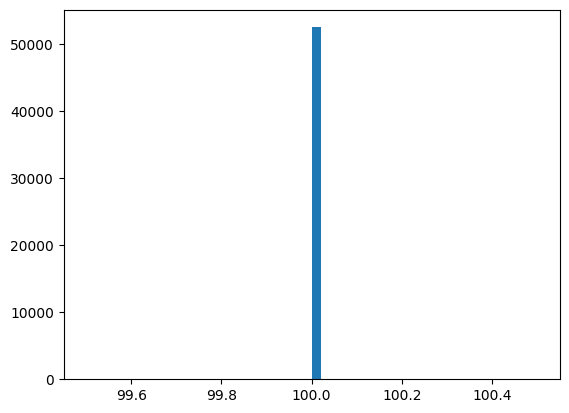

In [18]:
lens = [len(t['input_ids']) for t in tokenized_dataset]
plt.hist(lens, bins=50);

In [19]:
def detokenize(batch):
    batch["text"] = tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=False)
    return batch

In [20]:
tokenized_dataset = tokenized_dataset.map(
    detokenize, 
    batched=True,
    num_proc=4,
    desc="Running tokenizer on every text in dataset",
)

Running tokenizer on every text in dataset (num_proc=4):   0%|          | 0/52483 [00:00<?, ? examples/s]

In [21]:
print(tokenized_dataset[0])

{'input_ids': [101, 4907, 1005, 1055, 3008, 2020, 2058, 11179, 1012, 4907, 2001, 2058, 11179, 2004, 2092, 1012, 1996, 7435, 2409, 2010, 3008, 2009, 2001, 4895, 20192, 24658, 2100, 1012, 2010, 3008, 5319, 1998, 2787, 2000, 2191, 1037, 2689, 1012, 2027, 2288, 3209, 1998, 4907, 2006, 1037, 8738, 1012, 102, 101, 13223, 2018, 2074, 4342, 2129, 2000, 4536, 1037, 7997, 1012, 2016, 2134, 1005, 1056, 2031, 1037, 7997, 1997, 2014, 2219, 1012, 13223, 2052, 13583, 12271, 2006, 2014, 2905, 1005, 1055, 7997, 1012, 2016, 2288, 6091, 2006, 1037, 2940, 1998, 8007, 2046, 1037, 2813, 1012, 1996, 7997, 4853, 6260, 1998, 13223, 2288], 'special_tokens_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'text': "[CLS] dan's parents were overweight. dan was

In [22]:
dt_dict = tokenized_dataset.train_test_split(test_size=2700, seed=0)

In [23]:
dt_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'text'],
        num_rows: 49783
    })
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'text'],
        num_rows: 2700
    })
})

In [24]:
dt_dict["train"].save_to_disk(os.path.join(folder_path, "grouped_data/train"))

Saving the dataset (0/1 shards):   0%|          | 0/49783 [00:00<?, ? examples/s]

In [25]:
dt_dict["test"].save_to_disk(os.path.join(folder_path, "grouped_data/test"))

Saving the dataset (0/1 shards):   0%|          | 0/2700 [00:00<?, ? examples/s]

In [28]:
tokenizer("[CLS] dan's parents were overweight.[SEP]", add_special_tokens=False)

{'input_ids': [101, 4907, 1005, 1055, 3008, 2020, 2058, 11179, 1012], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [30]:
t5_tokenizer = AutoTokenizer.from_pretrained("t5-base")

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [34]:
t5_tokenizer.decode(t5_tokenizer("[CLS] dan's parents were overweight.[SEP]", add_special_tokens=True)["input_ids"], skip_special_tokens=False)

"[CLS] dan's parents were overweight.[SEP]</s>"

In [55]:
dt_dict["test"].select([1, 5, 4])

Dataset({
    features: ['input_ids', 'special_tokens_mask', 'text'],
    num_rows: 3
})

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [7]:
inps = torch.arange(6 * 3, dtype=torch.float32).view(6, 3)
dataset = TensorDataset(inps)

loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [8]:
iter_loader = iter(loader)

In [9]:
next(iter_loader)

[tensor([[0., 1., 2.],
         [3., 4., 5.]])]

In [10]:
next(iter_loader)

[tensor([[ 6.,  7.,  8.],
         [15., 16., 17.]])]

In [11]:
next(iter_loader)

[tensor([[12., 13., 14.],
         [ 9., 10., 11.]])]

In [25]:
iter_loader = iter(loader)

In [26]:
next(iter_loader)

[tensor([[ 3.,  4.,  5.],
         [12., 13., 14.]])]

In [27]:
next(iter_loader)

[tensor([[ 9., 10., 11.],
         [ 0.,  1.,  2.]])]

In [28]:
next(iter_loader)

[tensor([[ 6.,  7.,  8.],
         [15., 16., 17.]])]